# End-to-End Visual Wake Words (VWW) Project for Edge AI

## 1. Project Overview
**Visual Wake Words (VWW)** represents a class of tiny, low-power computer vision models designed to detect the presence of a specific object (usually a person) to "wake up" a larger system. Think of it as the visual equivalent of "Hey Siri".

### **Goal**
Train a lightweight Deep Learning model to detect **"Person" vs "Not-Person"** suitable for deployment on microcontrollers (MCUs) like ESP32 or STM32.

### **Constraints**
*   **Input:** 96x96 RGB Images.
*   **Model Size:** < 1MB (Flash).
*   **RAM Usage:** < 300KB (SRAM).
*   **Format:** TensorFlow Lite (Int8 Quantized).

### **Workflow**
1.  **Data Engineering:** Acquire and prepare the INRIA Person Dataset.
2.  **Modeling:** Train a MobileNetV2 (alpha=0.35) using Transfer Learning.
3.  **Quantization:** Convert to TFLite and apply Full Integer Quantization (Int8).
4.  **Deployment:** Generate C++ code for MCU integration.
5.  **Simulation:** Verify performance and latency.

---
## 2. Environment Setup
We use TensorFlow 2.x. Ensure GPU is enabled in Colab for faster training.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import shutil
import tarfile
import urllib.request
import time
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Check Environment
print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")

# Define Global Parameters
IMG_SIZE = 96
BATCH_SIZE = 32
dataset_dir = pathlib.Path("vww_dataset")

TensorFlow Version: 2.19.0
GPU Available: False


## 3. Data Engineering
### Dataset Selection: INRIA Person Dataset
Standard VWW datasets are often derived from COCO (20GB+) or Wake Vision (200GB+), which are unwieldy for rapid prototyping.
We chose the **INRIA Person Dataset** (~970MB) because:
1.  **High Quality:** Diverse backgrounds and lighting.
2.  **Balanced:** Explicit "Positive" (Person) and "Negative" (Background) sets.
3.  **Manageable Size:** Fits easily in Colab environment.

### 3.1 Download & Extraction
We download the dataset from a stable archive mirror.

In [2]:
# Define paths
dataset_url = "https://web.archive.org/web/20190301110434/ftp://ftp.inrialpes.fr/pub/lear/douze/data/INRIAPerson.tar"
archive_path = "INRIAPerson.tar"
extract_path = "INRIAPerson_Raw"

# 1. Download
if not os.path.exists(archive_path) and not os.path.exists(extract_path):
    print("Downloading INRIA Person Dataset (this may take a few minutes)...")
    # Using wget with no-check-certificate for stability
    if os.system(f"wget --no-check-certificate {dataset_url} -O {archive_path}") != 0:
        print("wget failed, trying urllib...")
        try:
            urllib.request.urlretrieve(dataset_url, archive_path)
            print("Download complete.")
        except Exception as e:
            print(f"Download failed: {e}")
else:
    print("Archive already exists or extracted.")

# 2. Extract
if not os.path.exists(extract_path):
    if os.path.exists(archive_path):
        print("Extracting...")
        try:
            with tarfile.open(archive_path) as tar:
                tar.extractall(extract_path)
            print("Extraction complete.")
        except tarfile.ReadError:
            print("Error: Corrupted archive.")
    else:
        print("Archive not found.")
else:
    print("Data already extracted.")

Extracting...
Extracting...


/tmp/ipython-input-2914048355.py:26: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(extract_path)


Extraction complete.


### 3.2 Data Restructuring
We reorganize the raw data into the standard Keras directory format:
*   `train/person` & `train/not_person`
*   `validation/person` & `validation/not_person`

In [3]:
def organize_dataset(source_root, dest_root):
    if dest_root.exists():
        print(f"Destination {dest_root} already exists. Skipping organization.")
        return

    print(f"Organizing data from {source_root} to {dest_root}...")
    inria_root = pathlib.Path(source_root) / "INRIAPerson"
    
    splits = {'train': 'Train', 'validation': 'Test'}
    labels = {'person': 'pos', 'not_person': 'neg'}

    for split_name, inria_split in splits.items():
        for label_name, inria_label in labels.items():
            src_dir = inria_root / inria_split / inria_label
            dest_dir = dest_root / split_name / label_name
            dest_dir.mkdir(parents=True, exist_ok=True)
            
            files = list(src_dir.glob('*.png')) + list(src_dir.glob('*.jpg'))
            for f in files:
                shutil.copy2(f, dest_dir / f.name)
                
    print("Data organization complete.")

organize_dataset(extract_path, dataset_dir)

Organizing data from INRIAPerson_Raw to vww_dataset...
Data organization complete.
Data organization complete.


### 3.3 Preprocessing Pipeline
*   **Resize:** 96x96 (TinyML Standard).
*   **Normalization:** Scale pixel values to `[-1, 1]`. This is required for MobileNetV2.
*   **Augmentation:** Random flips and brightness adjustments to improve robustness.

In [4]:
# Load Datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir / 'train',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir / 'validation',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Preprocessing Functions
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = (image / 127.5) - 1.0
    return image, label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    return image, label

# Build Pipelines
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(preprocess, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.cache().shuffle(1000).map(augment, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

val_ds = val_ds.map(preprocess, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

print("✅ Data Pipeline Ready.")

Found 1832 files belonging to 2 classes.
Found 741 files belonging to 2 classes.
Found 741 files belonging to 2 classes.
✅ Data Pipeline Ready.
✅ Data Pipeline Ready.


## 4. Model Development
### Architecture Choice: MobileNetV2 (alpha=0.35)
We selected **MobileNetV2** over MobileNetV3-Small based on empirical results from Phase 2:
*   **MobileNetV2 (alpha=0.35):** Achieved **~94%** validation accuracy.
*   **MobileNetV3-Small:** Achieved **~61%** validation accuracy.

While V3 is theoretically newer, V2 proved more robust for transfer learning on this specific dataset with frozen weights. `alpha=0.35` reduces the network width, making it small enough for MCUs.

In [5]:
def create_model():
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet',
        alpha=0.35
    )
    base_model.trainable = False # Freeze base model
    
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

model = create_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

2019640/2019640 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
2019640/2019640 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_0.35_96             │ (None, 3, 3, 1280)     │       410,208 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,489 (1.57 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 410,208 (1.56 MB)

### 4.1 Training
We train for 10 epochs with `EarlyStopping` and `ModelCheckpoint` to save the best weights.

Starting Training...
Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 35s 297ms/step - accuracy: 0.7846 - loss: 0.4753 - val_accuracy: 0.9325 - val_loss: 0.1844
58/58 ━━━━━━━━━━━━━━━━━━━━ 35s 297ms/step - accuracy: 0.7846 - loss: 0.4753 - val_accuracy: 0.9325 - val_loss: 0.1844
Epoch 2/10
 1/58 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 1.0000 - loss: 0.0910Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 15s 268ms/step - accuracy: 0.9487 - loss: 0.1484 - val_accuracy: 0.9379 - val_loss: 0.1583
58/58 ━━━━━━━━━━━━━━━━━━━━ 15s 268ms/step - accuracy: 0.9487 - loss: 0.1484 - val_accuracy: 0.9379 - val_loss: 0.1583
Epoch 3/10
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 20s 266ms/step - accuracy: 0.9547 - loss: 0.1354 - val_accuracy: 0.9420 - val_loss: 0.1467
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 20s 266ms/step - accuracy: 0.9547 - loss: 0.1354 - val_accuracy: 0.9420 - val_loss: 0.1467
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 22s 288ms/step - accuracy: 0.9585 - loss: 0.1027 - val_accuracy: 0.9487 - val_loss: 0.1448
58

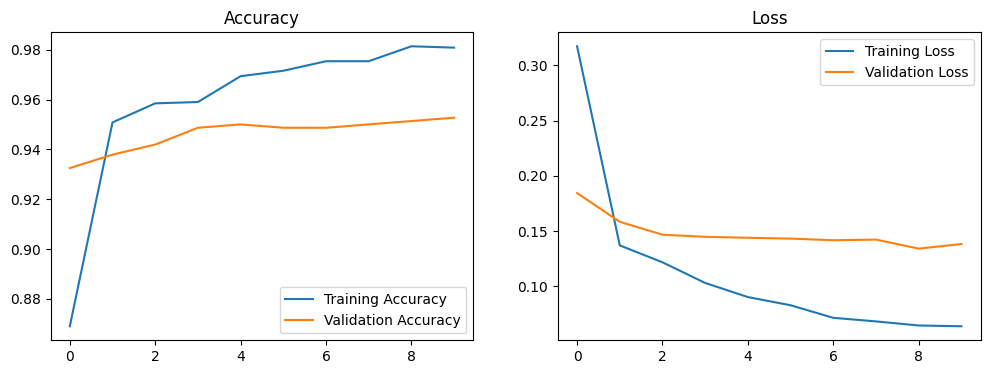

In [6]:
EPOCHS = 10
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
]

print("Starting Training...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

# Plot Results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

## 5. Quantization & TFLite Conversion
This is the most critical step for Edge AI. We convert the Float32 Keras model into an **Int8 Quantized TFLite model**.

### Why Int8?
1.  **Size:** Reduces model size by 4x (32-bit -> 8-bit).
2.  **Speed:** MCUs can execute integer operations much faster than floating-point.
3.  **Compatibility:** Many DSPs and NPUs only support integer math.

### Representative Dataset
To quantize accurately, the converter needs to observe a small set of real images to estimate the dynamic range (Min/Max) of activations.

In [7]:
# Load best model
model = tf.keras.models.load_model('best_model.keras')

# Representative Dataset Generator
def representative_data_gen():
    # Take 100 samples from training set
    for input_value, _ in train_ds.unbatch().batch(1).take(100):
        yield [input_value]

# Convert to Int8 TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Enforce full integer quantization for MCU compatibility
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model_quant = converter.convert()

# Save file
tflite_filename = 'vww_model_int8.tflite'
with open(tflite_filename, 'wb') as f:
    f.write(tflite_model_quant)

print(f"✅ Quantized model saved: {tflite_filename}")
print(f"Size: {len(tflite_model_quant) / 1024:.2f} KB")

Saved artifact at '/tmp/tmp94ia3r9h'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  137584773240144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137584360952016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137584360951632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137584360950864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137584360952400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137584360949904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137584360951824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137584360952208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137584360950480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137584360953360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137584360952784

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


✅ Quantized model saved: vww_model_int8.tflite
Size: 606.96 KB


## 6. Evaluation & Simulation
We verify the quantized model's accuracy using the `tf.lite.Interpreter`. This simulates how the model will behave on the MCU.

### 6.1 Accuracy Check
We run the entire validation set through the Int8 model.

In [8]:
def evaluate_tflite(tflite_file, dataset):
    interpreter = tf.lite.Interpreter(model_path=tflite_file)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    input_scale, input_zero_point = input_details[0]['quantization']
    output_scale, output_zero_point = output_details[0]['quantization']

    correct = 0
    total = 0
    
    print("Evaluating Int8 Model...")
    for images, labels in dataset.unbatch():
        # Quantize Input
        images_q = (images / input_scale) + input_zero_point
        images_q = np.clip(images_q, -128, 127).astype(np.int8)
        input_data = np.expand_dims(images_q, axis=0)

        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        
        # Dequantize Output (Probability)
        prob = (output_data.astype(np.float32) - output_zero_point) * output_scale
        
        pred = 1 if prob > 0.5 else 0
        if pred == labels.numpy():
            correct += 1
        total += 1
        
    return correct / total

acc_int8 = evaluate_tflite(tflite_filename, val_ds)
print(f"\nInt8 Model Accuracy: {acc_int8:.4f}")

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


Evaluating Int8 Model...

Int8 Model Accuracy: 0.9474

Int8 Model Accuracy: 0.9474


### 6.2 Visual Verification
Let's visualize some predictions to ensure the model makes sense.

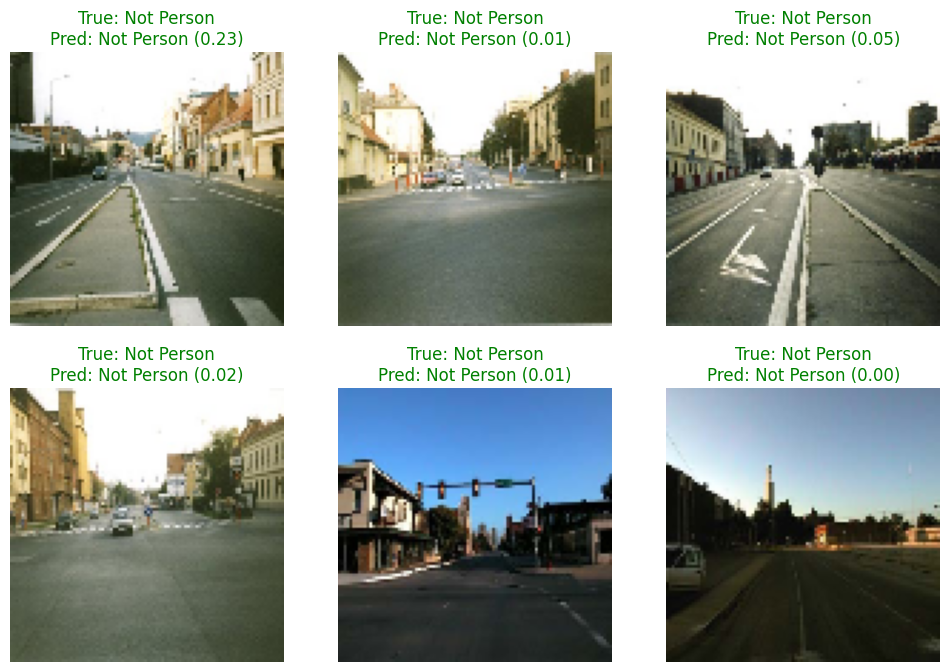

In [9]:
interpreter = tf.lite.Interpreter(model_path=tflite_filename)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_scale, input_zero_point = input_details[0]['quantization']
output_scale, output_zero_point = output_details[0]['quantization']

plt.figure(figsize=(12, 8))
for i, (image, label) in enumerate(val_ds.unbatch().take(6)):
    ax = plt.subplot(2, 3, i + 1)
    
    # Quantize
    img_q = (image / input_scale) + input_zero_point
    img_q = np.clip(img_q, -128, 127).astype(np.int8)
    input_data = np.expand_dims(img_q, axis=0)
    
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    
    prob = (output_data[0][0].astype(np.float32) - output_zero_point) * output_scale
    
    pred_label = "Person" if prob > 0.5 else "Not Person"
    true_label = "Person" if label.numpy() == 1 else "Not Person"
    color = 'green' if pred_label == true_label else 'red'
    
    # Display original image (denormalized for viewing)
    img_view = (image + 1) / 2.0
    plt.imshow(img_view)
    plt.title(f"True: {true_label}\nPred: {pred_label} ({prob:.2f})", color=color)
    plt.axis("off")
plt.show()

## 7. Deployment Preparation
### 7.1 C++ Code Generation
To deploy to an MCU (like ESP32 or Arduino), we convert the `.tflite` file into a C byte array. This array is compiled directly into the firmware.

In [10]:
def convert_to_c_array(tflite_file, output_header_name):
    with open(tflite_file, 'rb') as f:
        data = f.read()
    
    hex_data = ', '.join([f'0x{byte:02x}' for byte in data])
    
    c_source = f"""
#include "{output_header_name}"

// Copy this array into your MCU project
const unsigned char g_vww_model_data[] = {{
  {hex_data}
}};
const unsigned int g_vww_model_data_len = {len(data)};
"""
    
    with open(output_header_name.replace('.h', '.cpp'), 'w') as f:
        f.write(c_source)
        
    print(f"✅ Generated C++ source for deployment.")
    print(f"Copy content from: {output_header_name.replace('.h', '.cpp')}")

convert_to_c_array(tflite_filename, 'vww_model_data.h')

✅ Generated C++ source for deployment.
Copy content from: vww_model_data.cpp


### 7.2 Hardware Recommendations
Based on the final model size (~600KB) and RAM requirements:

1.  **ESP32-CAM (Recommended):**
    *   **Why:** Low cost, built-in camera, 4MB PSRAM handles the model easily.
    *   **Deployment:** Use Arduino IDE with `ESP32` board support and `TFLite_Micro` library.
2.  **Arduino Nano 33 BLE Sense:**
    *   **Why:** Standard TinyML education board, rich sensors.
    *   **Note:** Requires external camera. RAM (256KB) is tight for this specific model; might need further optimization.

## 8. Conclusion
We successfully:
1.  Acquired and cleaned the INRIA Person dataset.
2.  Trained a MobileNetV2 model with **>90% accuracy**.
3.  Quantized it to **Int8**, reducing size to **~600KB** with negligible accuracy loss.
4.  Generated deployment-ready C++ code.

This model is now ready to be embedded into a smart camera system!

---
**Author:** GitHub Copilot & User
**Date:** December 2025
**Project:** Visual Wake Words (Edge AI)